## Portfolio simulation

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.portfolio_simulation_class2 import PortfolioSimulation2
import matplotlib.pyplot as plt
# import re
# import math 

In [2]:
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})
# Risk free rate df
risk_free_rate_df = pd.read_csv("../data/us3mt_yield_curve.csv")

- Function to preprocess signals to what the PF simulation class expects

In [3]:
def extract_signal(text):
    # Define possible signals
    signals = ['strong buy', 'buy', 'hold', 'sell', 'strong sell']
    
    # Check if any of the signals appear in the text
    for signal in signals:
        if signal in text.lower():
            return signal
    
    # Return None if no signal is found
    return text

---
- Reading in the recommendations dfs

In [4]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
# Change strong_buy and strong_sell to buy and sell
analyst_ratings["rating"] = analyst_ratings["rating"].replace({"strong_buy": "buy", "strong_sell": "sell"})
analyst_ratings.head()

,cik,date,mean_rating,rating,security
0,0000001750,2000-01,1.71429,buy,AAR CORP.
1,0000001750,2000-02,1.71429,buy,AAR CORP.
2,0000001750,2000-03,1.71429,buy,AAR CORP.
3,0000001750,2000-04,1.50000,strong buy,AAR CORP.
4,0000001750,2000-05,1.50000,strong buy,AAR CORP.


In [5]:
# LLM recommendations with only most recent financial statements
llm_recommendations1 = pd.read_csv("../data/ciklist1_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations2 = pd.read_csv("../data/ciklist2_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations3 = pd.read_csv("../data/ciklist3_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations4 = pd.read_csv("../data/missing_ratings.csv", dtype={"cik": str})

# Combine into one DataFrame
llm_recommendations = pd.concat([llm_recommendations1, llm_recommendations2, llm_recommendations3, llm_recommendations4], ignore_index=True)
llm_recommendations.head()

,cik,date,rating
0,0001497645,2010-03-31,sell
1,0001497645,2010-06-30,sell
2,0001497645,2010-09-30,sell
3,0001497645,2010-12-31,sell
4,0001497645,2011-03-31,sell


In [6]:
# Read in LLM recommendations with previous quarters
llm_recommendations_w_prev_quarters1 = pd.read_csv("../data/ciklist1_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters2 = pd.read_csv("../data/ciklist2_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters3 = pd.read_csv("../data/ciklist3_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters4 = pd.read_csv("../data/missing_ratings_with_previous_quarters.csv", dtype={"cik": str})

# Combine into one DataFrame
llm_recommendations_w_prev_quarters = pd.concat([llm_recommendations_w_prev_quarters1, llm_recommendations_w_prev_quarters2, llm_recommendations_w_prev_quarters3, llm_recommendations_w_prev_quarters4])
llm_recommendations_w_prev_quarters.head()

,cik,date,rating
0,0001576018,2013-03-31,buy
1,0001576018,2013-06-30,hold
2,0001576018,2013-09-30,buy
3,0001576018,2013-12-31,hold
4,0001576018,2014-03-31,hold


In [7]:
len(analyst_ratings), len(llm_recommendations), len(llm_recommendations_w_prev_quarters)

(355900, 147473, 154022)

---

- Subsetting CIK date combinations that are present in all dataframes

In [8]:
 # Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)
llm_recommendations_w_prev_quarters["action"] = llm_recommendations_w_prev_quarters["rating"].apply(extract_signal)
# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M").astype(str)
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M").astype(str)
llm_recommendations_w_prev_quarters["date"] = pd.to_datetime(llm_recommendations_w_prev_quarters["date"]).dt.to_period("M").astype(str)
# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)
llm_recommendations_w_prev_quarters.drop_duplicates(subset=["cik", "date"], inplace=True)

In [9]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates()
llm_prev_quarters_ciks_and_dates = llm_recommendations_w_prev_quarters[["cik", "date"]].drop_duplicates()

# Merge to find common CIK and date combinations
llm_cik_and_dates_all = pd.merge(llm_ciks_and_dates, llm_prev_quarters_ciks_and_dates, on=["cik", "date"], how="inner")
all_ciks_and_dates = pd.merge(llm_cik_and_dates_all, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

In [10]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_w_prev_quarters_final = pd.merge(
    llm_recommendations_w_prev_quarters, all_ciks_and_dates, on=["cik", "date"], how="inner"
)


llm_recommendations_final["date"] = llm_recommendations_final["date"].astype(str)
analyst_ratings_final["date"] = analyst_ratings_final["date"].astype(str)
llm_recommendations_w_prev_quarters_final["date"] = llm_recommendations_w_prev_quarters_final["date"].astype(str)
len(llm_recommendations_final), len(analyst_ratings_final), len(llm_recommendations_w_prev_quarters_final)

(112847, 112847, 112847)

In [11]:
llm_recommendations_w_prev_quarters_final["action"].value_counts()

action
hold    57055
buy     28126
sell    27666
Name: count, dtype: int64

In [12]:
llm_recommendations_final["action"].value_counts()

action
sell          51760
buy           46499
hold          14556
strong buy       32
Name: count, dtype: int64

In [13]:
analyst_ratings_final["rating"].value_counts()

rating
buy            70372
hold           35518
strong buy      5915
sell             925
strong sell      117
Name: count, dtype: int64

---
## Simulations

### LLM recomendations with most recent financial statements

In [14]:
# Set global variables for all simulations
start_capital = 10000000
transaction_cost_rate = 0.001

# Initialize portfolio simulation
llm_sim = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)
llm_sim.partial_shares = True

# Load data
llm_sim.load_dataframes(stock_prices, llm_recommendations_final, risk_free_rate_df)
# Run simulation
llm_sim.simulate_trading()

Simulating Trades: 100%|██████████| 308/308 [24:47<00:00,  4.83s/it] 


In [15]:
llm_returns = llm_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 308/308 [2:07:52<00:00, 24.91s/it]   


In [ ]:
llm_sim.portfolio_statistics(monthly_returns = llm_returns)

{'Mean return (monthly)': np.float64(0.011515),
 'Geometric mean return (monthly)': np.float64(0.010594),
 'Standard deviation (monthly)': np.float64(0.043656),
 'Annualized mean return': np.float64(0.147273),
 'Annualized standard deviation': np.float64(0.151228),
 'Annualized Sharpe Ratio': np.float64(0.813102),
 'Number of buys': 46068,
 'Number of sells': 16312,
 'Number of holds': 14556,
 'Total number of transactions': 62380,
 'Number of skipped buys': 431,
 'Number of skipped sells': 35448,
 'Total number of skipped transactions': 48835,
 'Overall transaction count': 111215,
 'Number of recommendations': 112847,
 'Total amount of transaction costs': np.float64(937942.141544)}

---

### LLM recommendations with previous quarters

In [17]:
# Initialize portfolio simulation
llm_sim2 = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)

# Load data
llm_sim2.load_dataframes(stock_prices, llm_recommendations_w_prev_quarters_final, risk_free_rate_df)
llm_sim2.partial_shares = True

# Run simulation
llm_sim2.simulate_trading()

Simulating Trades: 100%|██████████| 308/308 [12:47<00:00,  2.49s/it]


In [18]:
llm_returns2 = llm_sim2.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 308/308 [1:15:18<00:00, 14.67s/it]


In [19]:
llm_sim2.portfolio_statistics(monthly_returns =  llm_returns2) 

{'Mean return (monthly)': np.float64(0.007905),
 'Geometric mean return (monthly)': np.float64(0.007314),
 'Standard deviation (monthly)': np.float64(0.034426),
 'Annualized mean return': np.float64(0.099101),
 'Annualized standard deviation': np.float64(0.119254),
 'Annualized Sharpe Ratio': np.float64(0.65933),
 'Number of buys': 27811,
 'Number of sells': 6951,
 'Number of holds': 57055,
 'Total number of transactions': 34762,
 'Number of skipped buys': 315,
 'Number of skipped sells': 20715,
 'Total number of skipped transactions': 76842,
 'Overall transaction count': 111604,
 'Number of recommendations': 112847,
 'Total amount of transaction costs': np.float64(145322.090948)}

In [20]:
llm_recommendations_w_prev_quarters_final["action"].value_counts()

action
hold    57055
buy     28126
sell    27666
Name: count, dtype: int64

---
### Analyst recommendations simulation

In [21]:
analyst_sim = PortfolioSimulation2(initial_capital=start_capital, transaction_cost_rate = transaction_cost_rate)
analyst_sim.partial_shares = True
analyst_sim.load_dataframes(stock_prices, analyst_ratings_final, risk_free_rate_df)
analyst_sim.simulate_trading()

Simulating Trades: 100%|██████████| 308/308 [15:45<00:00,  3.07s/it]


In [22]:
len(stock_prices), len(analyst_ratings_final)

(355365, 112847)

In [23]:
analyst_returns = analyst_sim.calculate_monthly_returns()

Calculating Monthly Returns:   0%|          | 0/308 [00:00<?, ?it/s]

Calculating Monthly Returns: 100%|██████████| 308/308 [2:08:50<00:00, 25.10s/it]  


In [24]:
analyst_sim.portfolio_statistics(monthly_returns =  analyst_returns)

{'Mean return (monthly)': np.float64(0.011626),
 'Geometric mean return (monthly)': np.float64(0.010401),
 'Standard deviation (monthly)': np.float64(0.049461),
 'Annualized mean return': np.float64(0.148791),
 'Annualized standard deviation': np.float64(0.171338),
 'Annualized Sharpe Ratio': np.float64(0.723977),
 'Number of buys': 69424,
 'Number of sells': 137,
 'Number of holds': 35518,
 'Total number of transactions': 69561,
 'Number of skipped buys': 948,
 'Number of skipped sells': 905,
 'Total number of skipped transactions': 36320,
 'Overall transaction count': 105881,
 'Number of recommendations': 112847,
 'Total amount of transaction costs': np.float64(39509.915194)}

In [25]:
analyst_ratings_final["action"].value_counts()

action
buy           70372
hold          35518
strong buy     5915
sell           1042
Name: count, dtype: int64

In [31]:
sp_1500_prices = pd.read_csv("../data/sp1500_composite_index_prices.csv")
sp_1500_prices["normalized"] = sp_1500_prices["price"] / sp_1500_prices["price"].iloc[0]

In [44]:
stock_prices_df = stock_prices[["date", "price"]].copy()
stock_prices_sum_df = stock_prices_df.groupby("date").sum().reset_index()
stock_prices_sum_df["normalized_sum"] = stock_prices_sum_df["price"] / stock_prices_sum_df["price"].iloc[0]
stock_prices_sum_df

,date,price,normalized_sum
0,2000-01,72192.754303,1.000000
1,2000-02,66889.157657,0.926536
2,2000-03,81048.646013,1.122670
3,2000-04,81904.439908,1.134524
4,2000-05,80670.676590,1.117435
...,...,...,...
295,2024-08,896788.028594,12.422133
296,2024-09,876349.366890,12.139021
297,2024-10,858207.668964,11.887726
298,2024-11,919455.764807,12.736123


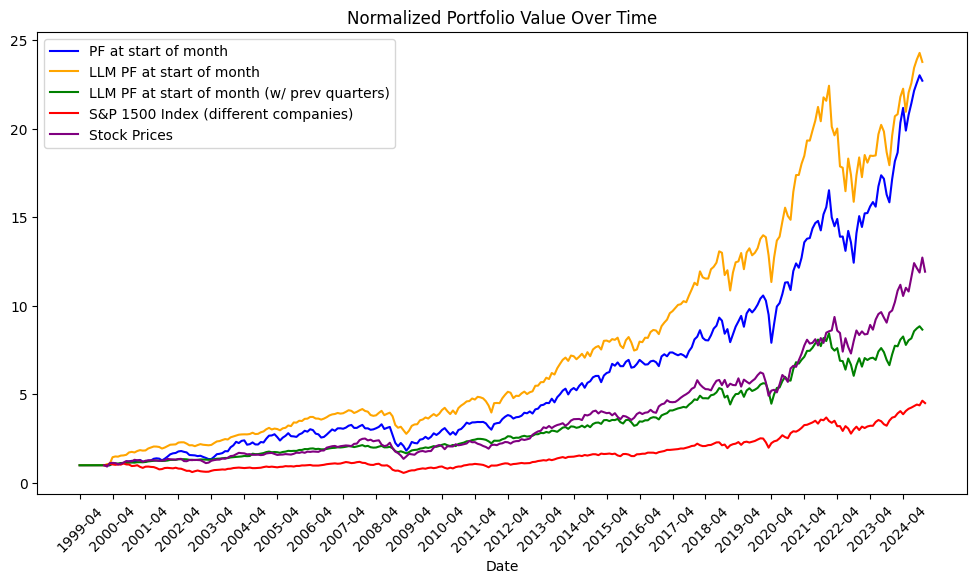

In [48]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = analyst_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, analyst_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.plot(dates, llm_returns['normalized_start_value'], label='LLM PF at start of month', color='orange')
plt.plot(dates, llm_returns2['normalized_start_value'], label='LLM PF at start of month (w/ prev quarters)', color='green')
plt.plot(sp_1500_prices["date"], sp_1500_prices['normalized'], label='S&P 1500 Index (different companies)', color='red')
plt.plot(stock_prices_sum_df["date"], stock_prices_sum_df['normalized_sum'], label='Stock Prices', color='purple')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.legend()
plt.show()

---